In [2]:
using Combinatorics
using BenchmarkTools
using Polynomials
using Plots
using Jacobi
using SparseArrays

In [3]:
##################
#sum_Tk 和 Prod_Tk是为了求laplace
#sum_Tk为(1)(2)
#Prod_Tk为(1)(2)中每一个乘积项
##################
function basis_function(N,d,x,k,range)
    Prod_Tk=zeros(N,N)
    Sum_Tk=zeros(1,N)
        for i=1:N
            for z=1:N
                Prod_temp=1
                for j=1:d
                    Prod_temp=Prod_temp*chebyshev(x[z,j],k[i,j])
                end
                Prod_Tk[i,z]=Prod_temp
            end
            Sum_Tk[i]=sum(Prod_Tk[i,:])
        end
    boundary_func=vcat(map(x->range^2-x^2, x))
    func_value=prod(Sum_Tk)*prod(boundary_func)
    #Sum_Tk=zeros(Float64,N)
    #Prod_Tk=zeros(Float64,N,N)
    #temp=[1.0*chebyshev(x[z,j],k[i,j]) for i=1:N for z=1:N for j=1:d]
    #temp=reshape(temp,d,N*N)
    #Prod_Tk=prod(temp,dims=1)
    #Prod_Tk=reshape(Prod_Tk,N,N)'
    #temp=prod(temp,dims=1)
    #temp=reshape(temp,N,N)
    #Sum_Tk=sum(temp,dims=1)'
    #temp=sum(temp,dims=1)
    #boundary_func=vcat(map(x->range^2-x^2, x))
    #func_value=prod(temp)*prod(boundary_func)
    return func_value,Sum_Tk,Prod_Tk,boundary_func
end

basis_function (generic function with 1 method)

In [4]:
##切比雪夫多项式二阶导
function d2chebyshev(x,k)
    chebyshev_Tk=Jacobi.chebyshev(x, k)
    chebyshev_Uk=Jacobi.chebyshev2(x, k)
    if x!=1&-1
        d2_Tk=k*((k+1)*chebyshev_Tk-chebyshev_Uk)/(x^2-1)
    end
    if x==1
        d2_Tk=(k^4-k^2)/3
    end
    if x==-1
        d2_Tk=(-1)^k*(k^4-k^2)/3
    end
    return d2_Tk
end

d2chebyshev (generic function with 1 method)

In [5]:
##基函数laplace
function laplace_psi(N,d,x,k,range)
    Sum_laplace=0
    Prod_laplace=0
    basisfunc=basis_function(N,d,x,k,range)[1]
    Sum_Tk=basis_function(N,d,x,k,range)[2]
    Prod_Tk=basis_function(N,d,x,k,range)[3]
        for dimension=1:d
            for N_x=1:N
                for i=1:N-1
                #################d2T####################
                d2T_k=d2chebyshev(x[N_x,dimension], k[i,dimension])
                T_k=Jacobi.chebyshev(x[N_x,dimension], k[i,dimension])
                Prod_laplace=basisfunc*d2T_k*Prod_Tk[i,N_x]/(Sum_Tk[i]*T_k)
                Sum_laplace+=Prod_laplace
                #################dTdT####################
                dT_ki=Jacobi.dchebyshev(x[N_x,dimension], k[i,dimension])
                T_k_i=Jacobi.chebyshev(x[N_x,dimension], k[i,dimension])
                    for j=i+1:N
                    dT_kj=Jacobi.dchebyshev(x[N_x,dimension], k[j,dimension])
                    T_k_j=Jacobi.chebyshev(x[N_x,dimension], k[j,dimension])
                    Prod_laplace=basisfunc*dT_kj*dT_ki*Prod_Tk[i,N_x]*Prod_Tk[j,N_x]/(Sum_Tk[i]*Sum_Tk[j]*T_k_i*T_k_j)
                    Sum_laplace+=2*Prod_laplace
                    end
                #################dTdx####################
                Prod_laplace=-2*x[N_x,dimension]*basisfunc*dT_ki*Prod_Tk[i,N_x]/(Sum_Tk[i]*(range^2-x[N_x,dimension]^2)*T_k_i)
                Sum_laplace+=2*Prod_laplace
                end
            T_k=Jacobi.chebyshev(x[N_x,dimension], k[N,dimension])
            d2T_k=d2chebyshev(x[N_x,dimension], k[N,dimension])
            Prod_laplace=basisfunc*d2T_k*Prod_Tk[N,N_x]/(Sum_Tk[N]*T_k)
            Sum_laplace+=Prod_laplace
            T_k_i=Jacobi.chebyshev(x[N_x,dimension], k[N,dimension])
            dT_ki=Jacobi.dchebyshev(x[N_x,dimension], k[N,dimension])
            Prod_laplace=-2*basisfunc*dT_ki*x[N_x,dimension]*Prod_Tk[N,N_x]/(Sum_Tk[N]*(range^2-x[N_x,dimension]^2)*T_k_i)
            Sum_laplace+=2*Prod_laplace
            #################d2x####################
            Sum_laplace+=-2*basisfunc/(range^2-x[N_x,dimension]^2)
            end
        end
    return Sum_laplace
end

laplace_psi (generic function with 1 method)

In [17]:
function V_psi(N,d,x,k,range)
    Sum_V=0
    Sum_r=sum(x.^2)
        Sum_V=basis_function(N,d,x,k,range)[1]*Sum_r
    return Sum_V
end

V_psi (generic function with 2 methods)

In [18]:
function H_psi(N,d,x,k,range)
       Sum_H_psi=-1/2*laplace_psi(N,d,x,k,range)+1/2*V_psi(N,d,x,k,range)
    return Sum_H_psi
end

H_psi (generic function with 2 methods)

In [19]:
#以M=3,N=2为例生成 
#3  0
#2  1
function nsumk(N,M)
    k=collect(partitions(M+N,N))
    k=vcat(map(e->collect(e)', k)...)
    k=k-ones(Int64,size(k))
    return k
end

nsumk (generic function with 1 method)

In [20]:
function find_k(d,N,M)
    k_all=zeros(Int64,1,N*d)
    for i=1:M
        dividers=nsumk(N*d,i)
        k_all=vcat(k_all, dividers)
    end
    k_all=sort!(k_all,dims =2)
    k_all=k_all'
    number_of_k=size(k_all)[2]
    i=0
    k=collect(permutations(k_all[1+i*N*d:N*d+i*N*d]))
    k=vcat(map(e->collect(e)', k)...)
    for i=1:number_of_k-1
        k_temp=collect(permutations(k_all[1+i*N*d:N*d+i*N*d]))
        k_temp=vcat(map(e->collect(e)', k_temp)...)
        k=vcat(k, k_temp)
        k=unique(k,dims=1)
    end
    k=k'
    number_of_k=size(k)[2]
    k=reshape(k,number_of_k*N*d)
    k=reshape(k,N,d,number_of_k)
    for i=1:number_of_k
        k[:,:,i]=sortslices(k[:,:,i],dims=1)
    end
    k=unique(k,dims=3)  
   return k
end

find_k (generic function with 1 method)

In [21]:
function random_choose(Number_of_x,d,N,k,range)
    Number_of_k=size(k)[3]
    random_choose_X=rand(N,d,Number_of_x).*rand([-range,range],N,d,Number_of_x)
    random_choose_psi_x=zeros(Number_of_k,Number_of_x)
    random_choose_Hpsi_x=zeros(Number_of_k,Number_of_x)
    for i=1:Number_of_k
        for j=1:Number_of_x
            random_choose_psi_x[i,j]=basis_function(N,d,random_choose_X[:,:,j],k[:,:,i],range)[1]
            random_choose_Hpsi_x[i,j]=H_psi(N,d,random_choose_X[:,:,j],k[:,:,i],range)
        end
    end
    return random_choose_psi_x,random_choose_Hpsi_x
end

random_choose (generic function with 1 method)

In [22]:
function least_squares(least_squares_x,least_squares_y)
    least_squares_C_k=inv(least_squares_x'*least_squares_x)*least_squares_x'*least_squares_y
    return least_squares_C_k
end

least_squares (generic function with 1 method)

In [32]:
function Eigenvalue(random_x,coef,alpha,d,N,k,range,Number_of_x;eps_x = 10^(-20),eps_d=0.001,maxIterations = 100)
    record=spzeros(maxIterations)
    basisfunction=random_x[1]
    H_basisfunction=random_x[2]
    for t in 1:maxIterations
            #若更换选点，取消以下注释
            #step_interval=10
            #if mod(t,step_interval)==0
                #random_x=random_choose(Number_of_x,d,N,k,range)
                #basisfunction=random_x[1]
                #H_basisfunction=random_x[2]
            #end
            reilaygh_quotient=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
            H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[2]
            coef=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[3]
            p=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[4]
            coef_H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[5]
            record[t]=reilaygh_quotient[1]
        if t>=3
            if abs(record[t]-record[t-1])+abs(record[t-1]-record[t-2])<=2*eps_d
                println("Convergence is reached after  ",t,"  iterations.")
                return coef,reilaygh_quotient,record
            end
        end
        alpha=steep(p,coef,reilaygh_quotient,coef_H_wave,basisfunction,N,d,range,H_basisfunction,Number_of_x,0,0.1,0.01,100)[1]
        println("============================步长为==========================",alpha)
        coef = coef-alpha*p
        println("At step ", t, " and reilaygh quotient = ", reilaygh_quotient)
    end
    println("Warning:",maxIterations,"  iterations have been exceeded")
    return coef,reilaygh_quotient,record
end

Eigenvalue (generic function with 1 method)

In [27]:
function reilaygh_quotient_alpha(coef_temp,basisfunction,H_basisfunction,N,d,range,Number_of_x)
        wave_temp=coef_temp*basisfunction
        sum_2_wave_temp=wave_temp*wave_temp'
        integal_wave_temp=(2*range)^(N*d)*sum_2_wave_temp/Number_of_x
        coef_temp=coef_temp/sqrt(integal_wave_temp[1])
        wave_temp=wave_temp/sqrt(integal_wave_temp[1])
        sum_2_wave_temp=sum_2_wave_temp/integal_wave_temp[1]
        H_wave_temp=coef_temp*H_basisfunction
        sum_wave_H_wave_temp=wave_temp*H_wave_temp'
        reilaygh_quotient_temp=sum_wave_H_wave_temp/sum_2_wave_temp
        coef_H_wave_temp=least_squares(basisfunction',H_wave_temp')
        coef_H_wave_temp=coef_H_wave_temp'
        p=coef_H_wave_temp-reilaygh_quotient_temp*coef_temp
    return reilaygh_quotient_temp,H_wave_temp,coef_temp,p,coef_H_wave_temp
end

reilaygh_quotient_alpha (generic function with 1 method)

In [28]:
function steep(p,coef,reilaygh_quotient,coef_H_wave,basisfunction,N,d,range,H_basisfunction,Number_of_x,a,b,eps_alpha,max)
        a_n=a
        b_n=b
        lambda=a+0.382*(b-a)
        mu=a+0.618*(b-a)
        phi_a=reilaygh_quotient_alpha(coef-a*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi_b=reilaygh_quotient_alpha(coef-b*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi_lambda=reilaygh_quotient_alpha(coef-lambda*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi_mu=reilaygh_quotient_alpha(coef-mu*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
        phi=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
        t=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[2]
        phi_max=findmax([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
    for i=1:max
        if t<3
            if b_n-a_n<eps_alpha
                return lambda
            end
            b_n=mu
            mu=lambda
            phi_b=phi_mu
            phi_mu=phi_lambda
            lambda=a_n+0.382*(b_n-a_n)
            phi_lambda=reilaygh_quotient_alpha(coef-lambda*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
            phi=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
            t=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[2]
            phi_max=findmax([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
        end
        if t>=3
           if b_n-a_n<eps_alpha
                return mu
           end
                a_n=lambda
                lambda=mu
                phi_a=phi_lambda
                phi_lambda=phi_mu
                mu=a_n+0.618*(b_n-a_n)
                phi_mu=reilaygh_quotient_alpha(coef-mu*p,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
                phi=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
                t=findmin([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[2]
                phi_max=findmax([phi_a[1],phi_lambda[1],phi_mu[1],phi_b[1]])[1]
        end
    end
    println("Warning:",max,"  iterations have been exceeded")
    return lambda
end

steep (generic function with 1 method)

In [50]:
##########################
#求 d=1 N=3 M=2:20 reilaygh quotient变化
#运行时间较长
##########################
d=1
N=3
M=2
k=find_k(d,N,M)
range=5
Number_k=size(k)[3]
c_k=ones(1,Number_k)
eps_x = 10^(-6)
eps_d=0.001
alpha=0.001
Number_of_x=40000
println("=================================M=",M,"==============================================")
println("========================选点并计算基函数值时间如下","==============================================")
@time random_x=random_choose(Number_of_x,d,N,k,range)
@time df1=Eigenvalue(random_x,c_k,alpha,d,N,k,range,Number_of_x;eps_x= 10^(-30),eps_d=10^(-7),maxIterations = 100000)[3]    
println("========================梯度下降时间如上","==============================================")
for M in 4:2:20
    println("=================================M=",M,"==============================================")
    k=find_k(d,N,M)
    Number_k=size(k)[3]
    c_k=ones(1,Number_k)
    println("========================选点并计算基函数值时间如下","==============================================")
    @time random_x=random_choose(Number_of_x,d,N,k,range)
    @time df2=Eigenvalue(random_x,c_k,alpha,d,N,k,range,Number_of_x;eps_x= 10^(-30),eps_d=10^(-7),maxIterations = 100000)[3]  
    println("========================梯度下降时间如上","==============================================")
    record=hcat(df1, df2)
    df1=record
end

=================================M=2==============================================
========================选点并计算基函数值时间如下==============================================
  0.429859 seconds (6.40 M allocations: 725.403 MiB, 15.26% gc time)
alpha=0.09655508457760001
At step 1 and reilaygh quotient = [9.979464518277226]
alpha=0.09655508457760001
At step 2 and reilaygh quotient = [7.879613663335357]
alpha=0.09655508457760001
At step 3 and reilaygh quotient = [5.0591659774458195]
alpha=0.09655508457760001
At step 4 and reilaygh quotient = [3.559225146903183]
alpha=0.09655508457760001
At step 5 and reilaygh quotient = [3.3256414357333908]
alpha=0.09655508457760001
At step 6 and reilaygh quotient = [3.3077251349302976]
alpha=0.09655508457760001
At step 7 and reilaygh quotient = [3.305558426759722]
alpha=0.09655508457760001
At step 8 and reilaygh quotient = [3.305075327981483]
alpha=0.09655508457760001
At step 9 and reilaygh quotient = [3.304941562098139]
alpha=0.09655508457760001
At step 10 and 

  4.714854 seconds (65.60 M allocations: 7.236 GiB, 19.29% gc time)
alpha=0.09655508457760001
At step 1 and reilaygh quotient = [15.867150270971337]
alpha=0.09655508457760001
At step 2 and reilaygh quotient = [12.522555069647671]
alpha=0.09655508457760001
At step 3 and reilaygh quotient = [10.868205438005862]
alpha=0.09655508457760001
At step 4 and reilaygh quotient = [9.566654049148678]
alpha=0.09655508457760001
At step 5 and reilaygh quotient = [8.512060377135183]
alpha=0.09655508457760001
At step 6 and reilaygh quotient = [7.624702931698897]
alpha=0.09655508457760001
At step 7 and reilaygh quotient = [6.884669112938965]
alpha=0.09655508457760001
At step 8 and reilaygh quotient = [6.269677079828523]
alpha=0.09655508457760001
At step 9 and reilaygh quotient = [5.7413792969177075]
alpha=0.09655508457760001
At step 10 and reilaygh quotient = [5.255826531073209]
alpha=0.09655508457760001
At step 11 and reilaygh quotient = [4.769731979091629]
alpha=0.09655508457760001
At step 12 and reila

alpha=0.056228606400000006
At step 30 and reilaygh quotient = [1.6142140982096054]
alpha=0.0652449154224
At step 31 and reilaygh quotient = [1.6050514895038444]
alpha=0.056228606400000006
At step 32 and reilaygh quotient = [1.5985177506461028]
alpha=0.0673760909776
At step 33 and reilaygh quotient = [1.5940046498540608]
alpha=0.056228606400000006
At step 34 and reilaygh quotient = [1.5907215871249674]
alpha=0.0652449154224
At step 35 and reilaygh quotient = [1.588461928586367]
alpha=0.056228606400000006
At step 36 and reilaygh quotient = [1.586809035626719]
alpha=0.0673760909776
At step 37 and reilaygh quotient = [1.5856730170853264]
alpha=0.056228606400000006
At step 38 and reilaygh quotient = [1.5848107102573152]
alpha=0.0673760909776
At step 39 and reilaygh quotient = [1.5842229406300201]
alpha=0.056228606400000006
At step 40 and reilaygh quotient = [1.583764159031907]
alpha=0.0708181032
At step 41 and reilaygh quotient = [1.5834517915045958]
alpha=0.050658321244800006
At step 42 an

alpha=0.032623909022400005
At step 51 and reilaygh quotient = [1.562242530813967]
alpha=0.07426233324655679
At step 52 and reilaygh quotient = [1.5594980340529954]
alpha=0.029181896800000003
At step 53 and reilaygh quotient = [1.5570571023396378]
alpha=0.09655508457760001
At step 54 and reilaygh quotient = [1.5552581372197192]
alpha=0.029181896800000003
At step 55 and reilaygh quotient = [1.5532894082123103]
alpha=0.09655508457760001
At step 56 and reilaygh quotient = [1.5522549984101404]
alpha=0.029181896800000003
At step 57 and reilaygh quotient = [1.5511760136050032]
alpha=0.09655508457760001
At step 58 and reilaygh quotient = [1.5505751557357583]
alpha=0.029181896800000003
At step 59 and reilaygh quotient = [1.549961962188109]
alpha=0.09655508457760001
At step 60 and reilaygh quotient = [1.549609679607797]
alpha=0.0270525154224
At step 61 and reilaygh quotient = [1.5492457755217723]
alpha=0.09655508457760001
At step 62 and reilaygh quotient = [1.5490372174113984]
alpha=0.0347550845

alpha=0.029181896800000003
At step 59 and reilaygh quotient = [1.580025389183467]
alpha=0.0347550845776
At step 60 and reilaygh quotient = [1.5707962240868316]
alpha=0.029181896800000003
At step 61 and reilaygh quotient = [1.562991172396779]
alpha=0.0347550845776
At step 62 and reilaygh quotient = [1.5559972175904668]
alpha=0.029181896800000003
At step 63 and reilaygh quotient = [1.5501165042352731]
alpha=0.0347550845776
At step 64 and reilaygh quotient = [1.5448224426813106]
alpha=0.029181896800000003
At step 65 and reilaygh quotient = [1.5404015088446161]
alpha=0.0347550845776
At step 66 and reilaygh quotient = [1.536396317752572]
alpha=0.029181896800000003
At step 67 and reilaygh quotient = [1.5330781279678025]
alpha=0.0347550845776
At step 68 and reilaygh quotient = [1.5300480896501236]
alpha=0.029181896800000003
At step 69 and reilaygh quotient = [1.5275603411705259]
alpha=0.0347550845776
At step 70 and reilaygh quotient = [1.5252670697092152]
alpha=0.029181896800000003
At step 71

alpha=0.0180344122224
At step 48 and reilaygh quotient = [4.053544553380296]
alpha=0.032623909022400005
At step 49 and reilaygh quotient = [3.9213176947261665]
alpha=0.0180344122224
At step 50 and reilaygh quotient = [3.7980903131897663]
alpha=0.029181896800000003
At step 51 and reilaygh quotient = [3.670671038569382]
alpha=0.0180344122224
At step 52 and reilaygh quotient = [3.557163378183028]
alpha=0.032623909022400005
At step 53 and reilaygh quotient = [3.445390189882356]
alpha=0.0180344122224
At step 54 and reilaygh quotient = [3.332123555597567]
alpha=0.029181896800000003
At step 55 and reilaygh quotient = [3.223997879187844]
alpha=0.020165587777600004
At step 56 and reilaygh quotient = [3.1232596739940788]
alpha=0.0236076
At step 57 and reilaygh quotient = [3.027340795998415]
alpha=0.0236076
At step 58 and reilaygh quotient = [2.939431774804452]
alpha=0.020165587777600004
At step 59 and reilaygh quotient = [2.8535642270262627]
alpha=0.0270525154224
At step 60 and reilaygh quotient

alpha=0.0124623332465568
At step 7 and reilaygh quotient = [14.632222938798355]
alpha=0.0360674538294711
At step 8 and reilaygh quotient = [14.10119225586214]
alpha=0.0124623332465568
At step 9 and reilaygh quotient = [13.539415907284916]
alpha=0.0270525154224
At step 10 and reilaygh quotient = [13.05430166006281]
alpha=0.0124623332465568
At step 11 and reilaygh quotient = [12.682235521385351]
alpha=0.0360674538294711
At step 12 and reilaygh quotient = [12.342043501311736]
alpha=0.011147484577600002
At step 13 and reilaygh quotient = [11.96936485349008]
alpha=0.0493416787552
At step 14 and reilaygh quotient = [11.617688470623278]
alpha=0.011147484577600002
At step 15 and reilaygh quotient = [11.210584984075187]
alpha=0.0360674538294711
At step 16 and reilaygh quotient = [10.842851419034869]
alpha=0.011147484577600002
At step 17 and reilaygh quotient = [10.57087049029417]
alpha=0.047210503200000004
At step 18 and reilaygh quotient = [10.308926753126089]
alpha=0.011147484577600002
At ste

alpha=0.011147484577600002
At step 110 and reilaygh quotient = [1.578247580137857]
alpha=0.025737666753443203
At step 111 and reilaygh quotient = [1.5719609348607126]
alpha=0.011147484577600002
At step 112 and reilaygh quotient = [1.5665693681529427]
alpha=0.032623909022400005
At step 113 and reilaygh quotient = [1.5620266214802196]
alpha=0.011147484577600002
At step 114 and reilaygh quotient = [1.556632500269812]
alpha=0.0270525154224
At step 115 and reilaygh quotient = [1.5522395040573078]
alpha=0.011147484577600002
At step 116 and reilaygh quotient = [1.548272379905379]
alpha=0.032623909022400005
At step 117 and reilaygh quotient = [1.5448944535537612]
alpha=0.011147484577600002
At step 118 and reilaygh quotient = [1.5411984149099194]
alpha=0.025737666753443203
At step 119 and reilaygh quotient = [1.5379017769719145]
alpha=0.011147484577600002
At step 120 and reilaygh quotient = [1.5351439248257432]
alpha=0.032623909022400005
At step 121 and reilaygh quotient = [1.5327810473659327]


alpha=0.011147484577600002
At step 12 and reilaygh quotient = [14.680923740402232]
alpha=0.014592400000000002
At step 13 and reilaygh quotient = [14.323475994535187]
alpha=0.011147484577600002
At step 14 and reilaygh quotient = [13.993170683679665]
alpha=0.0124623332465568
At step 15 and reilaygh quotient = [13.682249972092293]
alpha=0.0124623332465568
At step 16 and reilaygh quotient = [13.40422129581772]
alpha=0.0124623332465568
At step 17 and reilaygh quotient = [13.141333530495473]
alpha=0.011147484577600002
At step 18 and reilaygh quotient = [12.897711377346935]
alpha=0.014592400000000002
At step 19 and reilaygh quotient = [12.666248573121596]
alpha=0.011147484577600002
At step 20 and reilaygh quotient = [12.443716681648844]
alpha=0.0124623332465568
At step 21 and reilaygh quotient = [12.231977702977964]
alpha=0.0124623332465568
At step 22 and reilaygh quotient = [12.036278312564054]
alpha=0.011147484577600002
At step 23 and reilaygh quotient = [11.849360123247813]
alpha=0.0145924

alpha=0.0124623332465568
At step 114 and reilaygh quotient = [3.054410960442724]
alpha=0.011147484577600002
At step 115 and reilaygh quotient = [3.0040002527111715]
alpha=0.0124623332465568
At step 116 and reilaygh quotient = [2.9544863248967337]
alpha=0.011147484577600002
At step 117 and reilaygh quotient = [2.906538595584479]
alpha=0.0124623332465568
At step 118 and reilaygh quotient = [2.859165939501738]
alpha=0.011147484577600002
At step 119 and reilaygh quotient = [2.8137153046552204]
alpha=0.011147484577600002
At step 120 and reilaygh quotient = [2.7684817597326563]
alpha=0.0124623332465568
At step 121 and reilaygh quotient = [2.725388160132954]
alpha=0.011147484577600002
At step 122 and reilaygh quotient = [2.6824308909318755]
alpha=0.0124623332465568
At step 123 and reilaygh quotient = [2.6414592689877474]
alpha=0.011147484577600002
At step 124 and reilaygh quotient = [2.600992088505123]
alpha=0.011147484577600002
At step 125 and reilaygh quotient = [2.5621097925705474]
alpha=0

alpha=0.0124623332465568
At step 213 and reilaygh quotient = [1.5315207936738418]
alpha=0.011147484577600002
At step 214 and reilaygh quotient = [1.530358858933345]
alpha=0.011147484577600002
At step 215 and reilaygh quotient = [1.5292978567436353]
alpha=0.011147484577600002
At step 216 and reilaygh quotient = [1.5282246091595044]
alpha=0.0124623332465568
At step 217 and reilaygh quotient = [1.5272549732778582]
alpha=0.011147484577600002
At step 218 and reilaygh quotient = [1.5262622351165156]
alpha=0.011147484577600002
At step 219 and reilaygh quotient = [1.5253675377280163]
alpha=0.0124623332465568
At step 220 and reilaygh quotient = [1.524460640825966]
alpha=0.011147484577600002
At step 221 and reilaygh quotient = [1.5236355789853717]
alpha=0.011147484577600002
At step 222 and reilaygh quotient = [1.5227925835899065]
alpha=0.0124623332465568
At step 223 and reilaygh quotient = [1.52203663872872]
alpha=0.011147484577600002
At step 224 and reilaygh quotient = [1.5212609922836773]
alph

alpha=0.0180344122224
At step 315 and reilaygh quotient = [1.5021930205190026]
alpha=0.0090181032
At step 316 and reilaygh quotient = [1.5021564363570452]
alpha=0.014592400000000002
At step 317 and reilaygh quotient = [1.5021249301535984]
alpha=0.0090181032
At step 318 and reilaygh quotient = [1.5020920835404454]
alpha=0.0180344122224
At step 319 and reilaygh quotient = [1.5020651173347612]
alpha=0.0090181032
At step 320 and reilaygh quotient = [1.5020320742358126]
alpha=0.014592400000000002
At step 321 and reilaygh quotient = [1.5020038167428238]
alpha=0.0090181032
At step 322 and reilaygh quotient = [1.501974049162711]
alpha=0.0180344122224
At step 323 and reilaygh quotient = [1.5019498478227182]
alpha=0.0090181032
At step 324 and reilaygh quotient = [1.5019198869123065]
alpha=0.014592400000000002
At step 325 and reilaygh quotient = [1.50189450410944]
alpha=0.0090181032
At step 326 and reilaygh quotient = [1.5018674386400186]
alpha=0.0180344122224
At step 327 and reilaygh quotient = 

alpha=0.0055742968000000006
At step 418 and reilaygh quotient = [1.5007183550886196]
alpha=0.09655508457760001
At step 419 and reilaygh quotient = [1.5007174702631194]
alpha=0.0180344122224
At step 420 and reilaygh quotient = [1.5007052575427386]
alpha=0.0055742968000000006
At step 421 and reilaygh quotient = [1.500703007300828]
alpha=0.09655508457760001
At step 422 and reilaygh quotient = [1.5007018356548174]
alpha=0.011147484577600002
At step 423 and reilaygh quotient = [1.5006917607378831]
alpha=0.0055742968000000006
At step 424 and reilaygh quotient = [1.5006896398177685]
alpha=0.09655508457760001
At step 425 and reilaygh quotient = [1.5006890431706652]
alpha=0.0180344122224
At step 426 and reilaygh quotient = [1.500679851993899]
alpha=0.0055742968000000006
At step 427 and reilaygh quotient = [1.500678019818516]
alpha=0.09655508457760001
At step 428 and reilaygh quotient = [1.5006772476714332]
alpha=0.0124623332465568
At step 429 and reilaygh quotient = [1.5006696335139411]
alpha=0

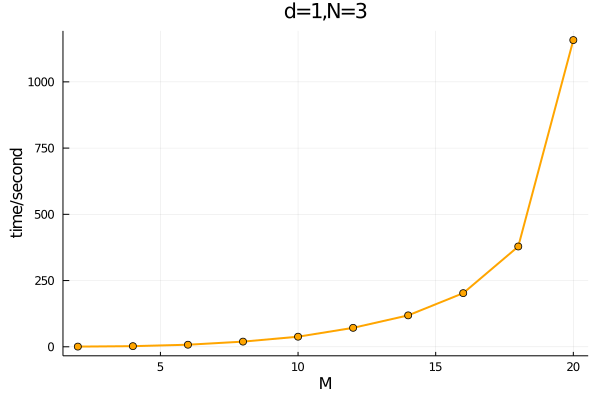

In [54]:
#画时间图
#没写函数，手动改时间。。
x=collect(2:2:20)
time=[0.293095+0.429859,1.313301+1.085863,2.614691+5.175826,4.714854+14.778792,7.623474+30.454066,12.123610+59.423014,18.228154+100.376995,25.576048+176.916978,36.163362+342.453232,43.929436+1113.821112 ]
Plots.plot(x,time,linewidth=2,title="d=1,N=3",xlabel="M",ylabel="time/second",label="",color="orange")
scatter!(x,time,label="",color="orange")

In [65]:
##改true_value 
true_value=1.5
record=df1
i=1
reilaygh_quotient_array1=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array1)
reilaygh_quotient_array1=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array1_ln=map((x) -> log(abs(x)), reilaygh_quotient_array1)

i=2
reilaygh_quotient_array2=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array2)
reilaygh_quotient_array2=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array2_ln=map((x) -> log(abs(x)), reilaygh_quotient_array2)

i=3
reilaygh_quotient_array3=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array3)
reilaygh_quotient_array3=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array3_ln=map((x) -> log(abs(x)), reilaygh_quotient_array3)

i=4
reilaygh_quotient_array4=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array4)
reilaygh_quotient_array4=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array4_ln=map((x) -> log(abs(x)), reilaygh_quotient_array4)

i=5
reilaygh_quotient_array5=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array5)
reilaygh_quotient_array5=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array5_ln=map((x) -> log(abs(x)), reilaygh_quotient_array5)

i=6
reilaygh_quotient_array6=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array6)
reilaygh_quotient_array6=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array6_ln=map((x) -> log(abs(x)), reilaygh_quotient_array6)

i=7
reilaygh_quotient_array7=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array7)
reilaygh_quotient_array7=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array7_ln=map((x) -> log(abs(x)), reilaygh_quotient_array7)

i=8
reilaygh_quotient_array8=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array8)
reilaygh_quotient_array8=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array8_ln=map((x) -> log(abs(x)), reilaygh_quotient_array8)

i=9
reilaygh_quotient_array9=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array9)
reilaygh_quotient_array9=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array9_ln=map((x) -> log(abs(x)), reilaygh_quotient_array9)

i=10
reilaygh_quotient_array10=findall(!iszero, record[:,i])
step=size(reilaygh_quotient_array10)
reilaygh_quotient_array10=Array(record[:,i][1:step[1]])-true_value*ones(step[1],1)
reilaygh_quotient_array10_ln=map((x) -> log(abs(x)), reilaygh_quotient_array10)

470×1 Array{Float64,2}:
  3.158837682178543
  3.038620679395168
  2.9502536324686015
  2.887569980529589
  2.8318783296491032
  2.785989711413386
  2.7435548655954114
  2.706271870978655
  2.6703977294971093
  2.638213275178927
  2.6071216704944344
  2.5787706131436225
  2.551277553160427
  ⋮
 -7.38600079982966
 -7.386381182213876
 -7.3864546072426815
 -7.386721263640849
 -7.3878951127326795
 -7.388156288973319
 -7.38822322595404
 -7.3916703368725845
 -7.392888507816067
 -7.393183766918792
 -7.3932272547611735
 -7.393390001907609

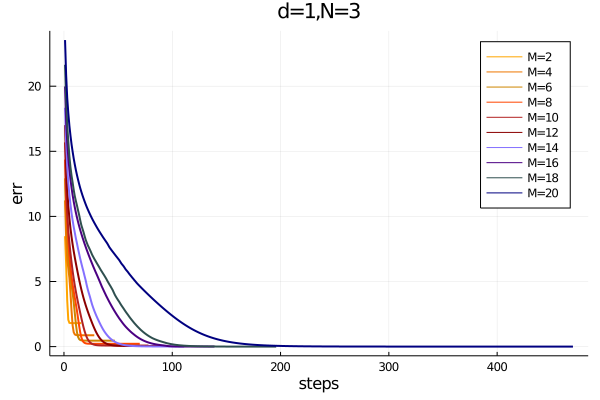

In [64]:

Plots.plot(reilaygh_quotient_array1,linewidth=2,title="d=1,N=3",xlabel="steps",ylabel="err",label="M=2",color="orange")
#scatter!(reilaygh_quotient_array1,label="",color="orange")

plot!(reilaygh_quotient_array2,linewidth=2,label="M=4",color="darkorange2")
#scatter!(reilaygh_quotient_array2,label="",color="darkorange2")

plot!(reilaygh_quotient_array3,linewidth=2,label="M=6",color="orange3")
#scatter!(reilaygh_quotient_array3,label="",color="orange3")

plot!(reilaygh_quotient_array4,linewidth=2,label="M=8",color="orangered")
#scatter!(reilaygh_quotient_array4,label="",color="orangered")

plot!(reilaygh_quotient_array5,linewidth=2,label="M=10",color="firebrick")
#scatter!(reilaygh_quotient_array5,label="",color="firebrick")

plot!(reilaygh_quotient_array6,linewidth=2,label="M=12",color="red4")
#scatter!(reilaygh_quotient_array6,label="",color="red4")

plot!(reilaygh_quotient_array7,linewidth=2,label="M=14",color="lightslateblue")
#scatter!(reilaygh_quotient_array7,label="",color="lightslateblue")

plot!(reilaygh_quotient_array8,linewidth=2,label="M=16",color="indigo")
#scatter!(reilaygh_quotient_array8,label="",color="indigo")

plot!(reilaygh_quotient_array9,linewidth=2,label="M=18",color="darkslategrey")
#scatter!(reilaygh_quotient_array9,label="",color="darkslategrey")

plot!(reilaygh_quotient_array10,linewidth=2,label="M=20",color="navy")
#scatter!(reilaygh_quotient_array10,label="",color="navy")

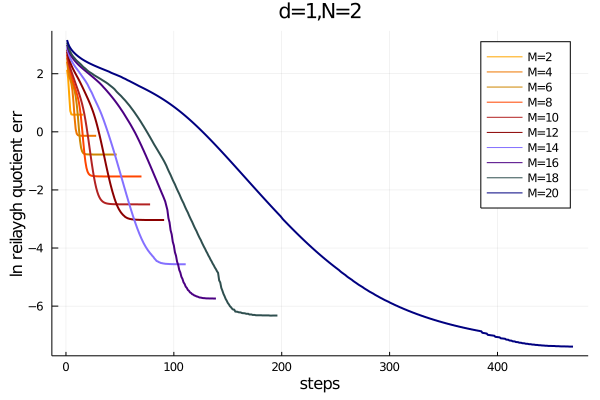

In [69]:
#plot(zeros(1:30),linewidth=1,ls=:dash,color="gray",label="")

Plots.plot(reilaygh_quotient_array1_ln,linewidth=2,title="d=1,N=3",xlabel="steps",ylabel="ln err",label="M=2",color="orange")
#scatter!(reilaygh_quotient_array1_ln,label="",color="orange")

plot!(reilaygh_quotient_array2_ln,linewidth=2,label="M=4",color="darkorange2")
#scatter!(reilaygh_quotient_array2_ln,label="",color="darkorange2")

plot!(reilaygh_quotient_array3_ln,linewidth=2,label="M=6",color="orange3")
#scatter!(reilaygh_quotient_array3_ln,label="",color="orange3")

plot!(reilaygh_quotient_array4_ln,linewidth=2,label="M=8",color="orangered")
#scatter!(reilaygh_quotient_array4_ln,label="",color="orangered")

plot!(reilaygh_quotient_array5_ln,linewidth=2,label="M=10",color="firebrick")
#scatter!(reilaygh_quotient_array5_ln,label="",color="firebrick")

plot!(reilaygh_quotient_array6_ln,linewidth=2,label="M=12",color="red4")
#scatter!(reilaygh_quotient_array6_ln,label="",color="red4")

plot!(reilaygh_quotient_array7_ln,linewidth=2,label="M=14",color="lightslateblue",title="d=1,N=2",xlabel="steps",ylabel="ln reilaygh quotient err")
#scatter!(reilaygh_quotient_array7_ln,label="",color="lightslateblue")

plot!(reilaygh_quotient_array8_ln,linewidth=2,label="M=16",color="indigo")
#scatter!(reilaygh_quotient_array8_ln,label="",color="indigo")

plot!(reilaygh_quotient_array9_ln,linewidth=2,label="M=18",color="darkslategrey")
#scatter!(reilaygh_quotient_array9_ln,label="",color="darkslategrey")

plot!(reilaygh_quotient_array10_ln,linewidth=2,label="M=20",color="navy")
#scatter!(reilaygh_quotient_array10_ln,label="",color="navy")

In [70]:
Plots.savefig("d=1N=3M=2:20.png")

In [74]:
err=[reilaygh_quotient_array1[size(reilaygh_quotient_array1)[1]][1],
    reilaygh_quotient_array2[size(reilaygh_quotient_array2)[1]],
    reilaygh_quotient_array3[size(reilaygh_quotient_array3)[1]],
    reilaygh_quotient_array4[size(reilaygh_quotient_array4)[1]],
    reilaygh_quotient_array5[size(reilaygh_quotient_array5)[1]],
    reilaygh_quotient_array6[size(reilaygh_quotient_array6)[1]],
    reilaygh_quotient_array7[size(reilaygh_quotient_array7)[1]],
    reilaygh_quotient_array8[size(reilaygh_quotient_array8)[1]],
    reilaygh_quotient_array9[size(reilaygh_quotient_array9)[1]],
    reilaygh_quotient_array10[size(reilaygh_quotient_array10)[1]]]
ln_err=map(x->log(abs(x)),err)

10-element Array{Float64,1}:
  0.590498276094101
 -0.13690848015794227
 -0.7810462669636268
 -1.5370483593248234
 -2.497221483314993
 -3.0362541291103664
 -4.558728781896874
 -5.738243574615974
 -6.324487351297294
 -7.393390001907609

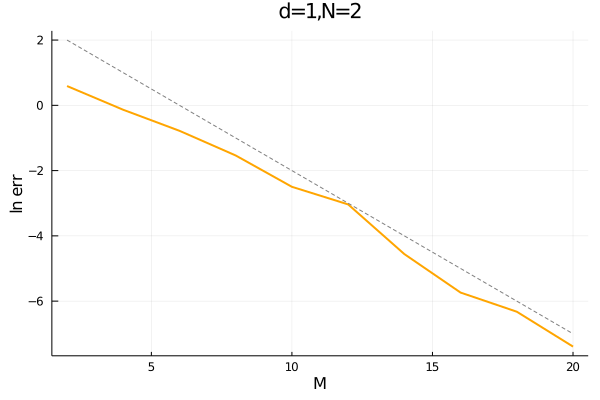

In [83]:
x=collect(2:2:20)
y=collect(2:-1:-7)
Plots.plot(x,ln_err,linewidth=2,label="",color="orange",xlabel="M",ylabel="ln err",title="d=1,N=2")
plot!(x,y,linewidth=1,ls=:dash,color="gray",label="")

In [84]:

function Eigenvalue1(random_x,coef,alpha,d,N,k,range,Number_of_x;eps_x = 10^(-20),eps_d=0.001,maxIterations = 100)
    record=spzeros(maxIterations)
    basisfunction=random_x[1]
    H_basisfunction=random_x[2]
    for t in 1:maxIterations
            #若更换选点，取消以下注释
            #step_interval=10
            #if mod(t,step_interval)==0
                #random_x=random_choose(Number_of_x,d,N,k,range)
                #basisfunction=random_x[1]
                #H_basisfunction=random_x[2]
            #end
            reilaygh_quotient=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
            H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[2]
            coef=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[3]
            p=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[4]
            coef_H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[5]
            record[t]=reilaygh_quotient[1]
        if t>=3
            if abs(record[t]-record[t-1])+abs(record[t-1]-record[t-2])<=2*eps_d
                println("Convergence is reached after  ",t,"  iterations.")
                return coef,reilaygh_quotient,record
            end
        end
        alpha=steep(p,coef,reilaygh_quotient,coef_H_wave,basisfunction,N,d,range,H_basisfunction,Number_of_x,0,0.1,0.01,100)[1]
        println("============================步长为==========================",alpha)
        coef = coef-alpha*p
        println("At step ", t, " and reilaygh quotient = ", reilaygh_quotient)
    end
    println("Warning:",maxIterations,"  iterations have been exceeded")
    return coef,reilaygh_quotient,record
end

Eigenvalue1 (generic function with 1 method)

In [91]:
d=1
N=4
M=20
@time k=find_k(d,N,M)
Number_of_x=40000
range=5
@time random_x=random_choose(Number_of_x,d,N,k,range)

  0.795926 seconds (1.73 M allocations: 589.698 MiB, 4.76% gc time)
109.236659 seconds (1.29 G allocations: 147.872 GiB, 17.60% gc time)


([4.570199215130467e7 4.0012369379277714e6 … 5.348818749728475e6 1.0916909759192657e7; -8.896108920337372e7 8.067546949628069e6 … 4.989190948249599e6 1.5356100794420497e7; … ; 1.6670572414750947e19 3.8341446223606084e22 … 4.343291824116672e22 3.512034355270838e20; 1.6458580220497699e19 2.6757040939728678e22 … 3.2079016179061032e22 1.2287387412246739e19], [4.0230797764545244e8 1.0369518592958483e8 … 1.2560682568011765e8 2.3133774436477414e8; -7.921824435232884e8 2.1137525974671584e8 … 1.1946184111782487e8 3.271327797724757e8; … ; -1.491259760294386e20 9.617177051719808e23 … 9.554890215965175e23 -9.755094750131892e20; -1.4570523428838949e20 6.579886330870388e23 … 6.95341778145022e23 -1.2807357543937244e21])

In [92]:
Number_k=size(k)[3]
coef=ones(1,Number_k)
eps_x = 10^(-6)
eps_d=0.001
alpha=0.001
@time A=Eigenvalue1(random_x,coef,alpha,d,N,k,range,Number_of_x;eps_x= 10^(-30),eps_d=10^(-7),maxIterations = 100000)

alpha=0.011147484577600002
At step 1 and reilaygh quotient = [27.048844640423138]
alpha=0.014592400000000002
At step 2 and reilaygh quotient = [23.981949129389115]
alpha=0.011147484577600002
At step 3 and reilaygh quotient = [22.087132423492566]
alpha=0.0124623332465568
At step 4 and reilaygh quotient = [20.664275759985586]
alpha=0.014592400000000002
At step 5 and reilaygh quotient = [19.660179851248504]
alpha=0.011147484577600002
At step 6 and reilaygh quotient = [18.75750502986504]
alpha=0.0124623332465568
At step 7 and reilaygh quotient = [18.032561972627775]
alpha=0.0124623332465568
At step 8 and reilaygh quotient = [17.3769984576848]
alpha=0.0124623332465568
At step 9 and reilaygh quotient = [16.840681939271466]
alpha=0.0124623332465568
At step 10 and reilaygh quotient = [16.32977699145163]
alpha=0.0124623332465568
At step 11 and reilaygh quotient = [15.901009605846902]
alpha=0.0124623332465568
At step 12 and reilaygh quotient = [15.486837132045515]
alpha=0.0124623332465568
At ste

alpha=0.011147484577600002
At step 104 and reilaygh quotient = [3.75570243944563]
alpha=0.011147484577600002
At step 105 and reilaygh quotient = [3.695797190447928]
alpha=0.0124623332465568
At step 106 and reilaygh quotient = [3.637005925495498]
alpha=0.011147484577600002
At step 107 and reilaygh quotient = [3.5797523146533345]
alpha=0.0124623332465568
At step 108 and reilaygh quotient = [3.523454687609018]
alpha=0.011147484577600002
At step 109 and reilaygh quotient = [3.469019971042393]
alpha=0.0124623332465568
At step 110 and reilaygh quotient = [3.415243653466355]
alpha=0.011147484577600002
At step 111 and reilaygh quotient = [3.363687150211969]
alpha=0.011147484577600002
At step 112 and reilaygh quotient = [3.312444206537702]
alpha=0.0124623332465568
At step 113 and reilaygh quotient = [3.2634036628773138]
alpha=0.011147484577600002
At step 114 and reilaygh quotient = [3.2150869959521358]
alpha=0.0124623332465568
At step 115 and reilaygh quotient = [3.1685047504236827]
alpha=0.011

LoadError: InterruptException:

In [ ]:
basisfunction=random_x[1]
H_basisfunction=random_x[2]
H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[2]
coef=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[3]
p=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[4]
coef_H_wave=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[5]
reilaygh_quotient=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]

In [ ]:
coef=A[1]
record_1=spzeros(10000)
t=1
for alpha=-0.2:0.01:0.2
    coef=A[1]
    coef=coef-alpha*p
    f_x=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
    record_1[t]=f_x[1]
    t=t+1
end

In [ ]:
coef=A[1]
coef=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[3]
p=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[4]
record_1=spzeros(10000)
coef=coef-0.01*p
coef=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[3]
p=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[4]
t=1
for alpha=-0.2:0.01:0.2
    coef=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[3]
    coef=coef-alpha*p
    f_x=reilaygh_quotient_alpha(coef,basisfunction,H_basisfunction,N,d,range,Number_of_x)[1]
    record_1[t]=f_x[1]
    t=t+1
end

In [ ]:
reilaygh_quotient_array=findall(!iszero, record_1)
step=size(reilaygh_quotient_array)
reilaygh_quotient_array=Array(record_1[1:step[1]])
findmin(reilaygh_quotient_array)

In [ ]:
x=collect(-0.2:0.01:0.2)
Plots.plot(x,reilaygh_quotient_array,linewidth=2,ylabel="f(x)",label="",xlabel="alpha")